In [ ]:
# https://stacindex.org/catalogs
# https://rasterio.readthedocs.io/en/stable/

In [1]:
import os
import folium
import shapely
import leafmap
import pystac
import rasterio
import rioxarray
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from itertools import chain
from datetime import datetime, date
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.transform import from_origin
from shapely.geometry import Point, Polygon, LinearRing
from shapely.geometry import box, shape
from rioxarray.merge import merge_arrays
from leafmap import foliumap
from folium.features import GeoJsonTooltip
from pystac import Catalog
from pystac_client import Client
from pyproj import CRS

In [2]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
COD_LAFAIETE = "3118304"

In [4]:
def bounds_to_ring(geom):
    minx, miny, maxx, maxy = geom.bounds
    return LinearRing([
        (minx, miny),
        (maxx, miny),
        (maxx, maxy),
        (minx, maxy),
        (minx, miny)
    ])

In [5]:
gdf_municipios = gpd.read_file('./data/archive/BR_Municipios_2020.shp')

In [6]:
crs = "EPSG:4326"
gdf_municipios = gdf_municipios.to_crs(crs)

In [7]:
# gdf_municipios['exterior'] = gdf_municipios.exterior
gdf_municipios['boundary'] = gdf_municipios.boundary
gdf_municipios["centroid"] = gdf_municipios.centroid
gdf_municipios["bounds"] = gdf_municipios.geometry.apply(bounds_to_ring)


In [8]:
gdf_mg = gdf_municipios[gdf_municipios['SIGLA_UF'] == 'MG']
gdf_lafa = gdf_mg[gdf_mg['NM_MUN'] == 'Conselheiro Lafaiete'].reset_index()

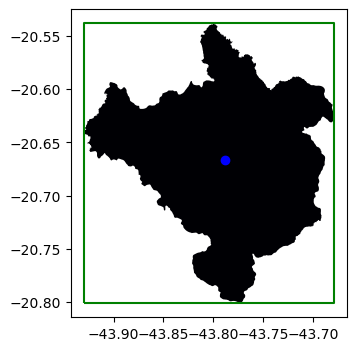

In [9]:
fig, ax = plt.subplots(figsize=(16,4))
gdf_centrod = gdf_lafa.set_geometry("centroid")
gdf_bounds = gdf_lafa.set_geometry("bounds")

gdf_lafa.plot(cmap="inferno", legend=True, ax=ax)
gdf_centrod.plot(ax=ax, color='blue')
gdf_bounds.plot(ax=ax, color='green')
plt.show()

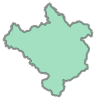

In [10]:
gdf_lafa.geometry.to_crs("EPSG:4326").geometry[0]

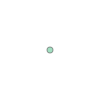

In [11]:
centroid = gdf_lafa.geometry.to_crs(epsg=4326).centroid.iloc[0]
centroid

In [12]:
gdf_sitio = gpd.read_file("./data/sitio.geojson")

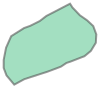

In [13]:
gdf_sitio.geometry.geometry[0]

## Buscando imagens

In [14]:
URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
URL = "https://earth-search.aws.element84.com/v1"  # Earth Search by Element 84 (earth-search-aws)
URL = "https://catalogue.dataspace.copernicus.eu/stac"  # Catalogue
URL = "https://landsatlook.usgs.gov/stac-server/"  # STAC API (stac-server)
URL = "https://bdc-sentinel-2.s3.us-west-2.amazonaws.com/catalog.json"  # BDC EO Data Cubes for Sentinel-2 (bdc-sentinel-2)
URL = "https://bdc-cbers.s3.us-west-2.amazonaws.com/catalog.json"  # BDC EO Data Cubes for CBERS (bdc-cbers)
URL = "https://earthengine.openeo.org/v1.0/"  # Google Earth Engine Proxy for openEO (openeo-earthengine-driver)
URL = "https://earthengine-stac.storage.googleapis.com/catalog/catalog.json"  # Google Earth Engine Catalog (GEE_catalog)
URL = "https://s3.eu-central-1.wasabisys.com/stac/openlandmap/catalog.json"  # OpenLandMap STAC (openlandmap)
URL = "https://esa-earthcode.github.io/open-science-catalog-metadata/catalog.json"  # Open Science Catalog (osc)
URL = "https://cmr.earthdata.nasa.gov/stac/"  # NASA Common Metadata Repository CMR-STAC API (CMR-STAC)
URL = "https://cmr.earthdata.nasa.gov/cloudstac/"  # NASA Common Metadata Repository CMR-CLOUDSTAC API (CMR-CLOUDSTAC)
URL = "https://raw.githubusercontent.com/scottyhq/sentinel1-rtc-stac/main/collection.json"  # Sentinel-1 RTC CONUS (sentinel1-rtc-aws)
URL = "https://tamn.snapplanet.io"  # Welcome to resto STAC (catalogs)
URL = "https://ai-extensions-stac.terradue.com"  # stac-fastapi (stac-fastapi)
URL = "https://stac.earthgenome.org/"  # Earth Genome STAC (earthgenome-stac)
URL = "https://s3ext.gptl.ru/stac-web-free/catalog.json"  # Roscosmos open datasets catalog
URL = "https://gpt.geocloud.com/sentinel/stac"  # Geoportal Server (Geoportal)
URL = "https://www.planet.com/data/stac/catalog.json"  # Planet Labs PBC - Open Data (planet)
URL = "https://api.ellipsis-drive.com/v3/ogc/stac/catalog/8a059125-b93d-4dda-b69b-9130fbe9f55e/epat_UK6PDdbzeJpySAvkdV55lztWjjrUZZmFzlYUQPbRFK2VnCxJQZ9twUJlv4ksKGc8"  # skyserve_mission_data (ellipsis-drive-stac-folder-8a059125-b93d-4dda-b69b-9130fbe9f55e)

In [21]:
URL = "https://www.planet.com/data/stac/catalog.json"
client = Client.open(url=URL)

In [22]:
for collection in client.get_collections():
    print(collection.id)

planet-stac-skysat
planet-disaster-data
planet/fusion/14N/29E-188N


In [18]:
COLLECTIONS = ["sentinel-2-l2a"]
start_date = date(2024, 11, 1)
end_date = date(2024, 11, 30)

In [19]:
aoi_bounds = shape(gdf_lafa.geometry.geometry[0]).bounds
aoi_geometry = gdf_lafa.geometry

response = client.search(
    collections=COLLECTIONS,
    query = {"eo:cloud_cover": {"lt": 50}},
    # bbox=aoi_bounds,
    intersects=aoi_geometry.to_crs("EPSG:4326").geometry[0].__geo_interface__,
    datetime=f"{start_date}/{end_date}",
    # datetime=[start_date, end_date],
    sortby="properties.datetime",
    max_items=20,
)
print(f"{response.matched()} items found")

3 items found


In [55]:
aoi_bounds = shape(gdf_sitio.geometry.geometry[0]).bounds
aoi_geometry = gdf_sitio.geometry

response = client.search(
    collections=COLLECTIONS,
    query = {"eo:cloud_cover": {"lt": 50}},
    # bbox=aoi_bounds,
    intersects=aoi_geometry.to_crs("EPSG:4326").geometry[0].__geo_interface__,
    datetime=f"{start_date}/{end_date}",
    # datetime=[start_date, end_date],
    sortby="properties.datetime",
    max_items=20,
)
print(f"{response.matched()} items found")

1 items found


In [56]:
response_items = response.get_all_items()
response_items

In [57]:
tfis = [
    {key: value.href for key, value in item.assets.items() if value.href.endswith(".tif")}
    for item in response_items
]

In [58]:
tfis[0]

{'aot': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/23/K/PT/2024/11/S2A_23KPT_20241128_0_L2A/AOT.tif',
 'blue': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/23/K/PT/2024/11/S2A_23KPT_20241128_0_L2A/B02.tif',
 'coastal': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/23/K/PT/2024/11/S2A_23KPT_20241128_0_L2A/B01.tif',
 'green': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/23/K/PT/2024/11/S2A_23KPT_20241128_0_L2A/B03.tif',
 'nir': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/23/K/PT/2024/11/S2A_23KPT_20241128_0_L2A/B08.tif',
 'nir08': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/23/K/PT/2024/11/S2A_23KPT_20241128_0_L2A/B8A.tif',
 'nir09': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/23/K/PT/2024/11/S2A_23KPT_20241128_0_L2A/B09.tif',
 'red': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/

In [59]:
NOT_BANDS = ['aot', 'scl', 'wvp', 'visual']

tfis_bands = [
    {key: value for key, value in item.items() if key not in NOT_BANDS}
    for item in tfis
]

In [60]:
tfis_bands[0]

{'blue': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/23/K/PT/2024/11/S2A_23KPT_20241128_0_L2A/B02.tif',
 'coastal': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/23/K/PT/2024/11/S2A_23KPT_20241128_0_L2A/B01.tif',
 'green': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/23/K/PT/2024/11/S2A_23KPT_20241128_0_L2A/B03.tif',
 'nir': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/23/K/PT/2024/11/S2A_23KPT_20241128_0_L2A/B08.tif',
 'nir08': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/23/K/PT/2024/11/S2A_23KPT_20241128_0_L2A/B8A.tif',
 'nir09': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/23/K/PT/2024/11/S2A_23KPT_20241128_0_L2A/B09.tif',
 'red': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/23/K/PT/2024/11/S2A_23KPT_20241128_0_L2A/B04.tif',
 'rededge1': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-

In [66]:
BANDS_NAME = []

tif_urls = list(chain.from_iterable([
    [value for key, value in item.items() if key not in BANDS_NAME]
    for item in tfis_bands
]))

In [67]:
tif_urls

['https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/23/K/PT/2024/11/S2A_23KPT_20241128_0_L2A/B02.tif',
 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/23/K/PT/2024/11/S2A_23KPT_20241128_0_L2A/B01.tif',
 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/23/K/PT/2024/11/S2A_23KPT_20241128_0_L2A/B03.tif',
 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/23/K/PT/2024/11/S2A_23KPT_20241128_0_L2A/B08.tif',
 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/23/K/PT/2024/11/S2A_23KPT_20241128_0_L2A/B8A.tif',
 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/23/K/PT/2024/11/S2A_23KPT_20241128_0_L2A/B09.tif',
 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/23/K/PT/2024/11/S2A_23KPT_20241128_0_L2A/B04.tif',
 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/23/K/PT/2024/11/S2A_23KPT_20241128_0_L2A/B05.tif',
 'https://sentin

In [68]:
bands_available = list(set(chain.from_iterable([item.keys() for item in tfis_bands])))
bands_available

['rededge3',
 'blue',
 'nir09',
 'nir',
 'swir22',
 'rededge1',
 'nir08',
 'swir16',
 'green',
 'red',
 'rededge2',
 'coastal']

### recortando aoi e salvando tif - 1

In [43]:
# gdf_geometry = gdf_lafa.geometry[0].__geo_interface__

# for idx, image_bands in enumerate(tfis_bands):
#     print(f"image: {idx}")

#     for key, url in image_bands.items():
#         print(f"band: {key}")

#         with rasterio.open(url) as src:
#             # out_image terá shape [count, height, width], onde 'count' = número de bandas
#             out_image, out_transform = rasterio.mask.mask(
#                 src, 
#                 shapes=[gdf_geometry], 
#                 crop=True,      # True para recortar no limite do polígono
#                 nodata=None     # opcional, defina valor de NoData se desejar
#             )

#             # Copiar metadados do raster original
#             out_meta = src.meta.copy()

#             # Atualizar metadados com novo tamanho e transform resultante do recorte
#             out_meta.update({
#                 "height": out_image.shape[1],  # número de linhas
#                 "width": out_image.shape[2],   # número de colunas
#                 "transform": out_transform
#             })
#     print("-"*50)


# # 4) Salvar a imagem recortada em um único arquivo GeoTIFF multibanda
# #    O count (número de bandas) permanece o mesmo do raster original.
# with rasterio.open("./data_output/saida_multiband_clip.tif", "w", **out_meta) as dest:
#     dest.write(out_image)

In [1]:
# TRAVA - MUITO PESADO
# for idx, image_bands in enumerate(tfis_bands):
#     print(f"image: {idx}")

#     bands_da = []
#     for key, url in image_bands.items():
#         print(f"band: {key}")

#         da = rioxarray.open_rasterio(url, masked=True)
#         da = da.assign_coords({"band_name": key})
#         bands_da.append(da)

#         # Concatena as bandas em uma dimensão "band"
#         combined = xr.concat(bands_da, dim="band")

#         # Ajusta a coord de "band" para algo indexável numericamente
#         # ou guarda um nome de banda. Depende do que preferir.
#         combined = combined.rename({"band": "fake_dim"})
#         combined = combined.assign_coords({"fake_dim": range(len(bands_da))})
#         combined = combined.rename({"fake_dim": "band"})

#         # Salva multibanda
#         combined.rio.to_raster("./data_output/multibanda.tif")

### recortando aoi e salvando tif - 1

In [69]:
files_generated = []

for idx, url in enumerate(tif_urls):
    ds = rioxarray.open_rasterio(url, masked=True)

    gdf_aoi = gdf_lafa.to_crs(ds.rio.crs)
    gdf_geometry = gdf_aoi.geometry[0].__geo_interface__
    gdf_crs = gdf_aoi.crs
    # gdf_aoi = aoi_geometry.to_crs("EPSG:4326").geometry[0].__geo_interface__

    # O rioxarray aceita tanto objetos GeoDataFrame quanto listas de geometria shapely
    clipped = ds.rio.clip(gdf_aoi.geometry, gdf_aoi.crs, drop=True)
    # clipped = ds.rio.clip(gdf_geometry, gdf_crs, drop=True)

    # Salvar o recorte
    file_path = f"./data_output/imagem_recortada_sitio_{idx}.tif"
    files_generated.append(file_path)
    clipped.rio.to_raster(file_path)

### recortando aoi e salvando tif - 2

In [32]:
geom_aoi = gdf_lafa.geometry.iloc[0]  # polígono de interesse
bounds = geom_aoi.bounds  # (minx, miny, maxx, maxy)

# Para cada TIF, lê só o pedaço que cruza o bounding box
for idx, href in enumerate(tif_urls):
    with rasterio.open(href) as src:
        window = src.window(*bounds)
        # windowed read
        clipped_data = src.read(window=window)  
        clipped.rio.to_raster(f"./data_output/imagem_recortada2_{idx}.tif")

### juntar tifs pelo arquivo local

In [70]:
# tifs_file = [
#     "./data_output/imagem_recortada_0.tif",
#     "./data_output/imagem_recortada_1.tif",
#     "./data_output/imagem_recortada_2.tif",
# ]

tifs_file = [
    "./data_output/imagem_recortada_sitio_0.tif",
    "./data_output/imagem_recortada_sitio_1.tif",
    "./data_output/imagem_recortada_sitio_2.tif",
    "./data_output/imagem_recortada_sitio_3.tif",
    "./data_output/imagem_recortada_sitio_4.tif",
    "./data_output/imagem_recortada_sitio_5.tif",
    "./data_output/imagem_recortada_sitio_6.tif",
    "./data_output/imagem_recortada_sitio_7.tif",
    "./data_output/imagem_recortada_sitio_8.tif",
    "./data_output/imagem_recortada_sitio_9.tif",
    "./data_output/imagem_recortada_sitio_10.tif",
    "./data_output/imagem_recortada_sitio_11.tif",
]

In [71]:
datasets = []
for file in tifs_file:
    # chunks="auto" indica ao rioxarray/dask para fragmentar o dado
    ds = rioxarray.open_rasterio(file, masked=True)
    datasets.append(ds)

In [72]:
# Faz o merge (mosaic) de forma "lazy"; a computação só acontece de fato quando você
# precisar dos dados (por exemplo, ao salvar em disco).
mosaic = merge_arrays(datasets)

In [73]:
# Se precisar salvar em disco, a computação ocorre neste momento
mosaic.rio.to_raster("./data_output/mosaic_recortado_sitio.tif")

In [74]:
lon, lat = centroid.x, centroid.y
m = leafmap.Map(center=(lat, lon), zoom=10)
m.add_raster("./data_output/mosaic_recortado_sitio.tif", layer_name="Mosaic Clipped")

In [1]:
# m

### juntar tifs pela url

In [31]:
# Ler cada GeoTIFF como um xarray.DataArray
datasets = [rioxarray.open_rasterio(url, masked=True) for url in tif_urls]

In [32]:
# Fazer o 'merge' de todos os datasets em um único raster (mosaic)
mosaic = merge_arrays(datasets)

In [33]:
item = response_items[2]

In [34]:
for band_key, asset in item.assets.items():
    print(f" - {band_key:<18}: {asset.title} -> {asset.href[-4:]}")

 - aot               : Aerosol optical thickness (AOT) -> .tif
 - blue              : Blue (band 2) - 10m -> .tif
 - coastal           : Coastal aerosol (band 1) - 60m -> .tif
 - granule_metadata  : None -> .xml
 - green             : Green (band 3) - 10m -> .tif
 - nir               : NIR 1 (band 8) - 10m -> .tif
 - nir08             : NIR 2 (band 8A) - 20m -> .tif
 - nir09             : NIR 3 (band 9) - 60m -> .tif
 - red               : Red (band 4) - 10m -> .tif
 - rededge1          : Red edge 1 (band 5) - 20m -> .tif
 - rededge2          : Red edge 2 (band 6) - 20m -> .tif
 - rededge3          : Red edge 3 (band 7) - 20m -> .tif
 - scl               : Scene classification map (SCL) -> .tif
 - swir16            : SWIR 1 (band 11) - 20m -> .tif
 - swir22            : SWIR 2 (band 12) - 20m -> .tif
 - thumbnail         : Thumbnail image -> .jpg
 - tileinfo_metadata : None -> json
 - visual            : True color image -> .tif
 - wvp               : Water vapour (WVP) -> .tif
 - aot-

In [35]:
len(item.assets.keys())

35

In [36]:
response_url = item.assets["visual"].href
response_url

'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/23/K/PS/2024/11/S2A_23KPS_20241128_0_L2A/TCI.tif'

In [38]:
# with rasterio.open(response_url) as src:
#     S2 = src.read()

src = rasterio.open(response_url)

In [39]:
rasterio.open("./data_output/lafaiete_item_3.tif", "w", **src.profile)

<open DatasetWriter name='./data_output/lafaiete_item_3.tif' mode='w'>

In [40]:
print(src.name)
print(src.mode)
print(src.closed)

https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/23/K/PS/2024/11/S2A_23KPS_20241128_0_L2A/TCI.tif
r
False


In [41]:
print(src.width)
print(src.height)
print(src.count)
print(src.meta)

10980
10980
3
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 10980, 'height': 10980, 'count': 3, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 23S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-45],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32723"]]'), 'transform': Affine(10.0, 0.0, 600000.0,
       0.0, -10.0, 7700020.0)}


In [42]:
print(src.bounds)
print(src.crs)
print(src.transform)

BoundingBox(left=600000.0, bottom=7590220.0, right=709800.0, top=7700020.0)
EPSG:32723
| 10.00, 0.00, 600000.00|
| 0.00,-10.00, 7700020.00|
| 0.00, 0.00, 1.00|


In [43]:
{i: dtype for i, dtype in zip(src.indexes, src.dtypes)}

{1: 'uint8', 2: 'uint8', 3: 'uint8'}

In [44]:
array = src.read()
stats = []

for band in array:
    stats.append({
        'min': band.min(),
        'mean': band.mean(),
        'median': np.median(band),
        'max': band.max()
    })

In [45]:
pd.DataFrame.from_dict(stats)

,min,mean,median,max
0,0,80.003992,67.0,255
1,0,91.052268,84.0,255
2,0,58.804231,49.0,255


In [46]:
array = src.read()
type(array)

numpy.ndarray

In [47]:
print(array.shape)

(3, 10980, 10980)


In [48]:
red = src.read(3)
green = src.read(2)
blue = src.read(1)

print(red.shape)
print(green.shape)
print(blue.shape)

(10980, 10980)
(10980, 10980)
(10980, 10980)


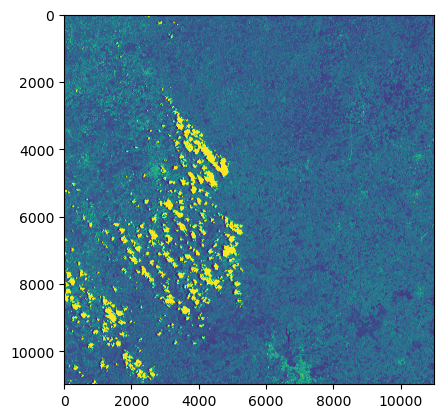

In [49]:
show(green)
plt.show()

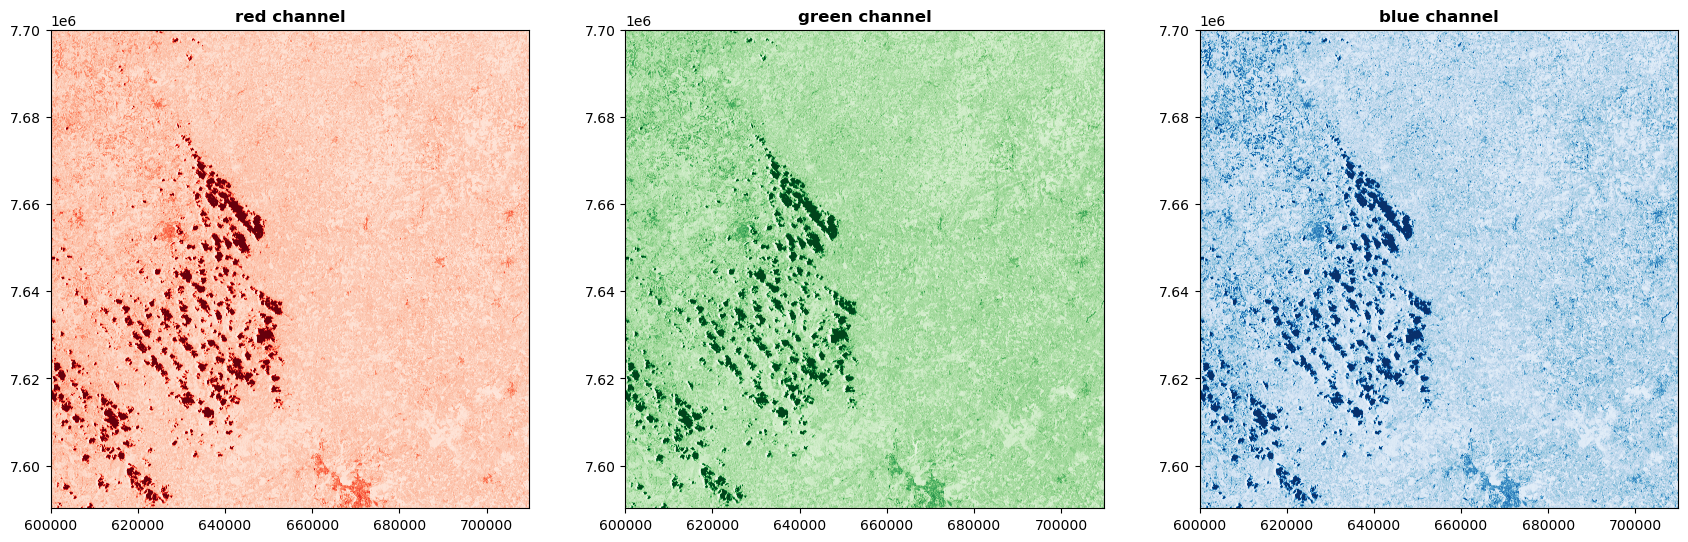

In [50]:
fig, (axr, axg, axb) = plt.subplots(1, 3, figsize=(21, 7))
show((src, 3), ax=axr, cmap='Reds', title='red channel')
show((src, 2), ax=axg, cmap='Greens', title='green channel')
show((src, 1), ax=axb, cmap='Blues', title='blue channel')
plt.show()

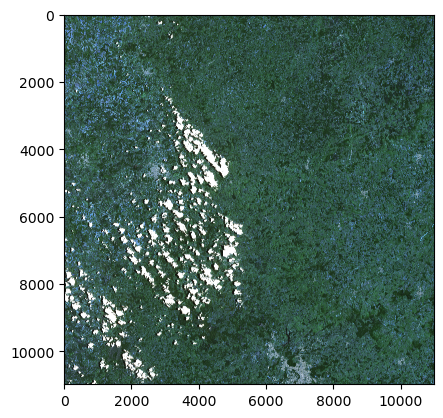

In [51]:
rgb = np.dstack((red, green, blue))
plt.imshow(rgb)
plt.show()

In [52]:
# show_hist(src, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram")